# ETL & Data Processing

## 1. Set up

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
%cd ..
# %cd media/capstone-project

D:\OneDrive\w210\capstone-project


In [2]:
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

%matplotlib inline
sns.set_theme(color_codes=True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

In [ ]:
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

In [ ]:
spark

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 2. EDA

In [11]:
raw_data = pd.read_csv('data/ddis_from_api_full.csv', delimiter='\t')
# Filter out drug_pairs without SMILES data
raw_data = raw_data.dropna(subset=['smiles1', 'smiles2', 'd1_name', 'd2_name', 'interaction'], how='any')
# Update All positive interactions to 1
raw_data['interaction_type'] = np.where(raw_data['interaction_type']==0, 0, 1)
raw_data = raw_data.drop_duplicates(('d1', 'd2'))

# Add a drug-pair column 
raw_data['d1_d2'] = raw_data.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
raw_data['drug_pair'] = raw_data.apply(lambda x: str(set(sorted([x['d1'], x['d2']]))), axis=1)

print('Raw data dimension:', raw_data.shape)
print('Number of distinct drugs in d1:', len(raw_data['d1'].unique()))
print('Number of distinct drugs in d2:', len(raw_data['d2'].unique()))
print('Number of distinct d1-d2 sequence:', len(raw_data['d1_d2'].unique()))
print('Number of distinct drug-pair:', len(raw_data['drug_pair'].unique()))
raw_data.head()

Raw data dimension: (1400774, 11)
Number of distinct drugs in d1: 2415
Number of distinct drugs in d2: 2448
Number of distinct d1-d2 sequence: 1400774
Number of distinct drug-pair: 755017


,d1,d2,d1_name,d2_name,interaction,severity,smiles1,smiles2,interaction_type,d1_d2,drug_pair
0,DB00006,DB02709,Bivalirudin,Resveratrol,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,OC1=CC=C(\C=C\C2=CC(O)=CC(O)=C2)C=C1,1,"['DB00006', 'DB02709']","{'DB02709', 'DB00006'}"
1,DB00006,DB01435,Bivalirudin,Antipyrine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CN1N(C(=O)C=C1C)C1=CC=CC=C1,1,"['DB00006', 'DB01435']","{'DB01435', 'DB00006'}"
2,DB00006,DB08867,Bivalirudin,Ulipristal,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.,unknown,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CN(C)C1=CC=C(C=C1)[C@H]1C[C@@]2(C)[C@@H](CC[C@]2(O)C(C)=O)[C@@H]2CCC3=CC(=O)CCC3=C12,1,"['DB00006', 'DB08867']","{'DB08867', 'DB00006'}"
3,DB00006,DB00428,Bivalirudin,Streptozocin,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CN(N=O)C(=O)N[C@H]1[C@@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O,1,"['DB00006', 'DB00428']","{'DB00428', 'DB00006'}"
4,DB00006,DB01138,Bivalirudin,Sulfinpyrazone,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,O=C1C(CCS(=O)C2=CC=CC=C2)C(=O)N(N1C1=CC=CC=C1)C1=CC=CC=C1,1,"['DB00006', 'DB01138']","{'DB01138', 'DB00006'}"


In [5]:
# Count the number of repeated pairs in the dataset
count_pair = dict(raw_data.d1_d2.value_counts())

# Display drug-pairs that have more than 1 interaction in the dataset
raw_data['count_pair'] = raw_data.d1_d2.map(count_pair)

pair_1count = len(raw_data[raw_data.count_pair == 1]['d1_d2'].unique())
pair_2count = len(raw_data[raw_data.count_pair > 1]['d1_d2'].unique())
print('Number of drug-pairs have 1 interaction:', pair_1count)
print('Number of drug-pairs have >1 interactions:', pair_2count)
# raw_data[raw_data.count_pair > 1].sort_values('d1_d2')

Number of drug-pairs have 1 interaction: 1400774
Number of drug-pairs have >1 interactions: 0


In [6]:
# Number of distinct Drugs in the dataset
all_drug_id = set(raw_data['d1'].unique()) | set(raw_data['d2'].unique())
print('Number of distinct drugs:', len(all_drug_id))

Number of distinct drugs: 2448


## 3. Extract Drug-Pair With Unknown-Interaction (Negative Control)

In [6]:
# SMILES dataset
drug_smiles = pd.read_csv('data/archive/drug_smiles.csv')
# drug_smiles = pd.read_csv('data/scraping_drug_smiles.csv')
# drug_smiles = drug_smiles[drug_smiles["SMILES"] != "Not Available"]
drug_smiles = drug_smiles[['drug_id', 'smiles']]

print('Drug Smiles dimension:', drug_smiles.shape)
drug_smiles.head()

Drug Smiles dimension: (1704, 2)


,drug_id,smiles
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1,DB00855,NCC(=O)CCC(O)=O
2,DB09536,O=[Ti]=O
3,DB01878,O=C(C1=CC=CC=C1)C1=CC=CC=C1
4,DB00140,CC1=C(C)C=C2N(C[C@H](O)[C@H](O)[C@H](O)CO)C3=NC(=O)NC(=O)C3=NC2=C1


In [7]:
# All potential Drug-Pair could be formed in the database
all_pairs = {str(set(pair)) for pair in itertools.combinations(sorted(drug_smiles.drug_id), 2)}
# all_pairs = {str(set(pair)) for pair in itertools.combinations(sorted(all_drug_id), 2)}
print("Total pairs could be formed:", len(all_pairs))

# All drug-pair with known interactions
interact_pairs = {pair for pair in raw_data.drug_pair.unique()}
print("Number of pairs have interactions:", len(interact_pairs))

# All drug-pair with NO interactions found
# negative_pairs = [pair for pair in all_pairs if pair not in interact_pairs]
negative_pairs = all_pairs - interact_pairs
print("Number of pairs with NO interactions found:", len(negative_pairs))

print("Quick look of negative control drug pairs:")
list(negative_pairs)[:10]

Total pairs could be formed: 1450956
Number of pairs have interactions: 755017
Number of pairs with NO interactions found: 1022612
Quick look of negative control drug pairs:


["{'DB00293', 'DB06712'}",
 "{'DB00381', 'DB00362'}",
 "{'DB00905', 'DB00338'}",
 "{'DB05260', 'DB00330'}",
 "{'DB00462', 'DB01087'}",
 "{'DB01588', 'DB13146'}",
 "{'DB06282', 'DB09021'}",
 "{'DB00352', 'DB08865'}",
 "{'DB06626', 'DB11231'}",
 "{'DB00992', 'DB01095'}"]

In [ ]:
# def convert_pair_to_df(negative_pairs):
#     string_rdd = sc.parallelize(list(negative_pairs))
#     negative_rdd = string_rdd.map(lambda x: re.sub('[{}\']', '', x).split(", "))
#     negative_df = negative_rdd.toDF(["d1", "d2"]).toPandas()
#     return negative_df
    
# negative_df = convert_pair_to_df(negative_pairs)
# negative_df

In [8]:
negative_df = pd.DataFrame(negative_pairs)
negative_df.columns = ['drug_pair']
negative_df['d1'] = negative_df['drug_pair'].apply(lambda x: re.sub('[{}\']', '', x).split(", ")[0])
negative_df['d2'] = negative_df['drug_pair'].apply(lambda x: re.sub('[{}\']', '', x).split(", ")[1])
negative_df = negative_df.drop('drug_pair', axis=1)
negative_df

,d1,d2
0,DB00293,DB06712
1,DB00381,DB00362
2,DB00905,DB00338
3,DB05260,DB00330
4,DB00462,DB01087
...,...,...
1022607,DB00743,DB00474
1022608,DB01416,DB00938
1022609,DB00992,DB06605
1022610,DB00542,DB04845


In [12]:
# # Drug Name
# drug_names = pd.read_csv('data/archive/drugbank vocabulary.csv')
# drug_names = drug_names[['DrugBank ID', 'Common name']]
# # drug_names = pd.read_csv('data/scraping_drug_info.csv', delimiter='\t')
# # drug_names = drug_names[['drug_id', 'generic_name', 'SMILES']]
# drug_names = drug_names.rename(columns={'DrugBank ID': 'drug_id', 'Common name':'name'})
#
# print('Drug Names dimension:', drug_names.shape)
# drug_names.head()

In [9]:
# SMILES dataset
drug_smiles2 = pd.read_csv('data/scraping_drug_smiles.csv')
drug_smiles2 = drug_smiles2[drug_smiles2["SMILES"] != "Not Available"]
# drug_smiles2 = drug_smiles2[['drug_id', 'smiles']]

print('Drug Smiles dimension From Web Scraping:', drug_smiles2.shape)
drug_smiles2.head()

Drug Smiles dimension From Web Scraping: (2567, 3)


,drug_id,generic_name,SMILES
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC2=C1C=CC=C2)NC(=O)[C@H](CC1=CNC=N1)NC(=O)[C@@H]1CCC(=...
2,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H](CC1=CC=C(O)C=C1)NC(=O)[C@H](CO)NC(=O)[C@H](CC1=CNC2=CC=CC=C12)NC(=O)[C@H](CC1=CN=CN1)NC(=O)[C@@H]1CCC(=O)N1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1...
3,DB00027,Gramicidin D,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(=O)N[C@@H](C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](C(C)C)C(=O)N[C@H](C(C)C)C(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](CC1=CNC2=C1C=CC=C2...
4,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)[C@H](CC2=CC=C(O)C=C2)NC(=O)CCSSC[C@H](NC(=O)[C@H](CC(N)=O)NC1=O)C(=O)N1CCC[C@H]1C(=O)N[C@H](CCCNC(N)=N)C(=O)NCC(N)=O


In [10]:
# Add Interaction Type and Smiles1, Smiles 2 into negative_df
merged_df = pd.merge(negative_df, drug_smiles2, left_on="d1", right_on="drug_id", how="left")
merged_df = merged_df.rename(columns={"generic_name": "d1_name", "SMILES": "smiles1"})
# merged_df = pd.merge(negative_df, drug_names, left_on="d1", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"name": "d1_name"})

merged_df = pd.merge(merged_df, drug_smiles2, left_on="d2", right_on="drug_id", how="left")
merged_df = merged_df.rename(columns={"generic_name": "d2_name", "SMILES": "smiles2"})
# merged_df = pd.merge(merged_df, drug_names, left_on="d2", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"name": "d2_name"})                                      

merged_df['interaction'] = 'Unknown'
merged_df['interaction_type'] = 0
merged_df['severity'] = 'unknown'


# merged_df = pd.merge(merged_df, drug_smiles, left_on="d1", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"smiles": "smiles1"})

# merged_df = pd.merge(merged_df, drug_smiles, left_on="d2", right_on="drug_id", how="left")
# merged_df = merged_df.rename(columns={"smiles": "smiles2"})

merged_df = merged_df[['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2']]
merged_df = merged_df.dropna(subset=['smiles1', 'smiles2', 'd1_name', 'd2_name'], how='any')
merged_df.head(2)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00293,DB06712,Raltitrexed,Nilvadipine,Unknown,0,unknown,CN(CC1=CC2=C(NC(C)=NC2=O)C=C1)C1=CC=C(S1)C(=O)N[C@@H](CCC(O)=O)C(O)=O,COC(=O)C1=C(NC(C)=C(C1C1=CC(=CC=C1)[N+]([O-])=O)C(=O)OC(C)C)C#N
1,DB00381,DB00362,Amlodipine,Anidulafungin,Unknown,0,unknown,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=O)OC,[H][C@]1(NC(=O)[C@@H](NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)[C@H](C[C@@H](O)[C@@H](O)NC(=O)[C@@H]2[C@@H](O)[C@@H](C)CN2C1=O)NC(=O)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(OCCCCC)C=C1)[C@@H](C)O)[C@...


## 4. Combine Interaction Data & Negative Control Data

In [20]:
raw_data = raw_data[['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2']]
master_df = pd.concat([merged_df, raw_data])
# master_df = master_df.dropna(subset=['smiles1', 'smiles2', 'd1_name', 'd2_name', 'interaction_type'], how='any')
master_df = master_df.dropna(subset=['smiles1'], how='any')
master_df = master_df.dropna(subset=['smiles2'], how='any')
master_df = master_df.dropna(subset=['interaction_type'], how='any')

master_df = master_df.drop_duplicates()
master_df = master_df.sort_values(by='d1')

master_df.reset_index(inplace=True)
master_df = master_df.drop('index', axis=1)

print("Shape of Master data:", master_df.shape)
print('Number of distinct drugs in d1:', len(master_df['d1'].unique()))
print('Number of distinct drugs in d2:', len(master_df['d2'].unique()))
total_drugs = set(master_df['d1'].unique()) | set(master_df['d2'].unique())
print('Number of distinct drugs:', len(total_drugs))
print("Value Count of Interaction Type")
print(master_df['interaction_type'].value_counts())
# print("Value Count of Interaction Type - Bottom 20:")
# print(master_df['interaction_type'].value_counts()[-20:])
print('Number of missing values:\n', master_df.isnull().sum())

Shape of Master data: (2403016, 9)
Number of distinct drugs in d1: 2538
Number of distinct drugs in d2: 2567
Number of distinct drugs: 2567
Value Count of Interaction Type
1    1400774
0    1002242
Name: interaction_type, dtype: int64
Number of missing values:
 d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
dtype: int64


In [15]:
master_df.head(2)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00006,DB00621,Bivalirudin,Oxandrolone,Unknown,0,unknown,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,[H][C@@]12CC[C@](C)(O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]2([H])CC(=O)OC[C@]12C
1,DB00006,DB09053,Bivalirudin,Ibrutinib,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC1=NC=NC2=C1C(=NN2[C@@H]1CCCN(C1)C(=O)C=C)C1=CC=C(OC2=CC=CC=C2)C=C1


In [22]:
master_df[master_df["smiles1"].isnull()]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2


In [23]:
master_df[master_df["smiles1"] == '']

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2


In [24]:
master_df[master_df["smiles1"] == ' ']

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2


In [31]:
master_df[master_df["d2_name"] == 'Sodium phosphate']

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2


In [30]:
master_df[master_df["interaction"] == 'The risk or severity of myopathy']

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2


In [4]:
# Save data
# master_df.to_csv("data/binary_ddi/ddis_from_api_binary.csv", index=False, sep='\t')
master_df = pd.read_csv("data/binary_ddi/ddis_from_api_binary.csv", sep='\t')

In [5]:
test_drug = master_df[master_df['d1']=='DB00338']
print(test_drug.shape)
# test_drug.head(2)
test_drug[test_drug['interaction_type'] != 0][test_drug['severity'] == 'high'].head(2)

(1557, 9)


C:\Users\ltmai\AppData\Local\Temp\ipykernel_24976\1879203424.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_drug[test_drug['interaction_type'] != 0][test_drug['severity'] == 'high'].head(2)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
238234,DB00338,DB00738,Omeprazole,Pentamidine,The metabolism of #Drug2 can be decreased when combined with #Drug1.,1,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,NC(=N)C1=CC=C(OCCCCCOC2=CC=C(C=C2)C(N)=N)C=C1
238457,DB00338,DB01035,Omeprazole,Procainamide,The metabolism of #Drug2 can be decreased when combined with #Drug1.,1,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,CCN(CC)CCNC(=O)C1=CC=C(N)C=C1


In [6]:
test_drug[test_drug['d2_name'] == "Testosterone"]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
239366,DB00338,DB00624,Omeprazole,Testosterone,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.,1,unknown,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C


In [7]:
# Add a drug-pair column 
# master_df['d1_d2'] = master_df.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
# raw_data['drug_pair'] = raw_data.apply(lambda x: str(set(sorted([x['d1'], x['d2']]))), axis=1)

print('Raw data dimension:', master_df.shape)
print('Number of distinct drugs in d1:', len(master_df['d1'].unique()))
print('Number of distinct drugs in d2:', len(master_df['d2'].unique()))
# print('Number of distinct d1-d2 sequence:', len(master_df['d1_d2'].unique()))

Raw data dimension: (2403016, 9)
Number of distinct drugs in d1: 2538
Number of distinct drugs in d2: 2567


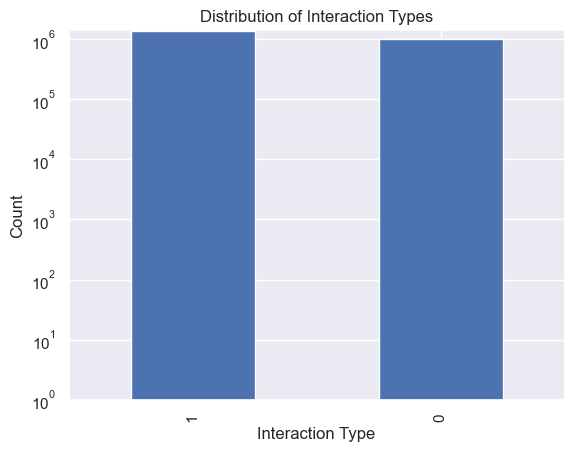

In [8]:
master_df['interaction_type'].value_counts().plot(kind='bar', logy=True)
sns.set_style('white')

plt.ylabel('Count')
plt.xlabel('Interaction Type')
plt.title('Distribution of Interaction Types')
labels = [0, 1]
plt.xticks(labels)
plt.ylim(bottom=1) 
plt.show()

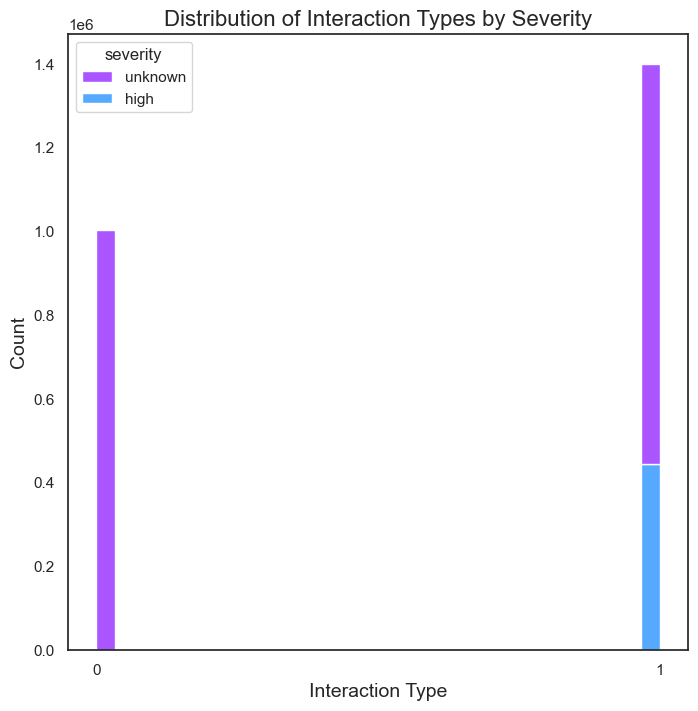

In [21]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=master_df, x='interaction_type', bins = 30, alpha=1, hue="severity", multiple="stack", palette='cool_r')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Interaction Type', fontsize=14)
plt.title('Distribution of Interaction Types by Severity', fontsize=16)
# plt.xticks(rotation=0)
# labels = list(range(0, 90, 5))
labels = [0, 1]
plt.xticks(labels)
plt.show()

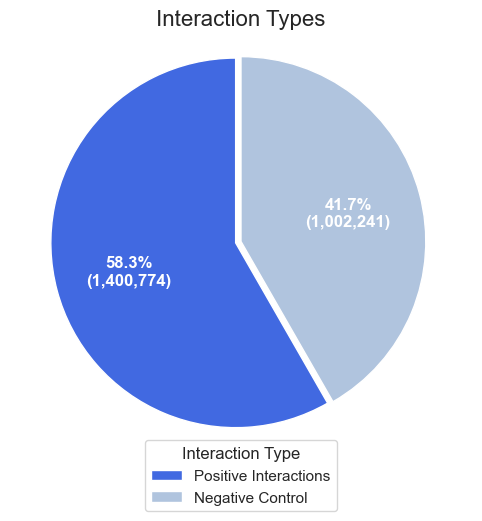

In [22]:
data = [master_df[master_df['interaction_type'] != 0].shape[0], master_df[master_df['interaction_type'] == 0].shape[0]]
labels = ['Positive Interactions', 'Negative Control']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Interaction Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1)
         )

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Interaction Types", fontsize=16, y=0.95)
plt.show()

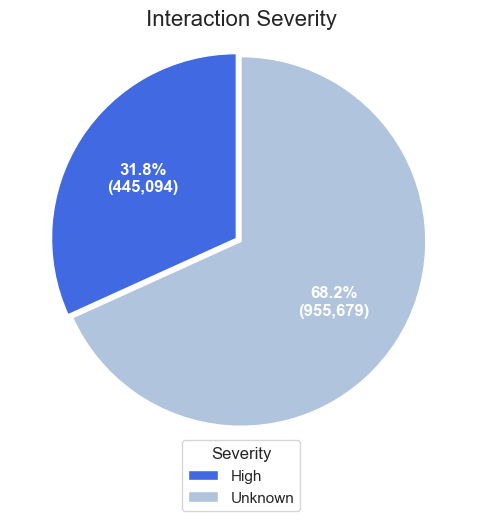

In [23]:
positive_df = master_df[master_df['interaction_type'] == 1]
data = [positive_df[positive_df['severity'] == 'high'].shape[0], positive_df[positive_df['severity'] != 'high'].shape[0]]
labels = ['High', 'Unknown']


def func(pct, allvals):                    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Severity",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Interaction Severity", fontsize=16, y=0.95)
plt.show()

In [ ]:
# # Save new interaction_information
# interaction_df = master_df[['interaction_type', 'interaction']]
# interaction_df = interaction_df.drop_duplicates().sort_values('interaction_type')
# interaction_df.reset_index(inplace=True)
# interaction_df = interaction_df.drop('index', axis=1)
# interaction_df

In [ ]:
# # save the dataframe to csv file
# interaction_df.to_csv('data/interaction_information_api.csv', index=False, sep='\t')

## 5. Train / Test Split

In [10]:
master_df.head(2)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00006,DB00721,Bivalirudin,Procaine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCN(CC)CCOC(=O)C1=CC=C(N)C=C1
1,DB00006,DB02546,Bivalirudin,Vorinostat,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,ONC(=O)CCCCCCC(=O)NC1=CC=CC=C1


In [18]:
## Extract Bit in the Approved Group
drug_info_df = pd.read_csv('data/scraping_drug_info.csv', delimiter='\t')
approved_drugs = drug_info_df[drug_info_df["approved_drug"] == 1]["drug_id"].values
not_approved_drugs = drug_info_df[drug_info_df["approved_drug"] != 1]["drug_id"].values
print("Number of approved drugs:", len(approved_drugs))
print("Number of not approved drugs:", len(not_approved_drugs))


Number of approved drugs: 2040
Number of not approved drugs: 527


In [17]:
## Add Target and Mechanism of Action to Master DataFrame
target_df = drug_info_df[["drug_id", "target", "mechanism_of_action"]]

# Drug 1 merging
master_df2 = pd.merge(master_df, target_df, left_on="d1", right_on="drug_id", how="left")
master_df2 = master_df2.rename(columns={"target": "d1_target", "mechanism_of_action": "d1_action"})

# Drug 2 merging
master_df2 = pd.merge(master_df2, target_df, left_on="d2", right_on="drug_id", how="left")
master_df2 = master_df2.rename(columns={"target": "d2_target", "mechanism_of_action": "d2_action"})
master_df2 = master_df2.drop(["drug_id_x", "drug_id_y"], axis=1)
print('Number of missing values:\n', master_df2.isnull().sum())

master_df2.head()


Number of missing values:
 d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
interaction_type    0
severity            0
smiles1             0
smiles2             0
d1_target           0
d1_action           0
d2_target           0
d2_action           0
dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB00006,DB00721,Bivalirudin,Procaine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCN(CC)CCOC(=O)C1=CC=C(N)C=C1,"Category: A, Protein: Prothrombin, Actions: inhibitor","Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding exosite. Thrombin is a serine proteinase that plays a central role in the thrombotic process, acting ...","Category: A, Protein: Sodium channel protein type 10 subunit alpha, Actions: inhibitor | Category: A, Protein: Glutamate receptor ionotropic, NMDA 3A, Actions: antagonist | Category: A, Protein: 5...","Procaine acts mainly by inhibiting sodium influx through voltage gated sodium channels in the neuronal cell membrane of peripheral nerves. When the influx of sodium is interrupted, an action poten..."
1,DB00006,DB02546,Bivalirudin,Vorinostat,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,ONC(=O)CCCCCCC(=O)NC1=CC=CC=C1,"Category: A, Protein: Prothrombin, Actions: inhibitor","Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding exosite. Thrombin is a serine proteinase that plays a central role in the thrombotic process, acting ...","Category: A, Protein: Histone deacetylase 1, Actions: inhibitor | Category: A, Protein: Histone deacetylase 2, Actions: inhibitor | Category: A, Protein: Histone deacetylase 3, Actions: inhibitor ...","Vorinostat inhibits the enzymatic activity of histone deacetylases HDAC1, HDAC2 and HDAC3 (Class I) and HDAC6 (Class II) at nanomolar concentrations (IC50< 86 nM). These enzymes catalyze the remov..."
2,DB00006,DB01101,Bivalirudin,Capecitabine,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,CCCCCOC(=O)NC1=NC(=O)N(C=C1F)[C@@H]1O[C@H](C)[C@@H](O)[C@H]1O,"Category: A, Protein: Prothrombin, Actions: inhibitor","Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding exosite. Thrombin is a serine proteinase that plays a central role in the thrombotic process, acting ...","Category: A, Protein: DNA, Actions: incorporation into and destabilization | Category: A, Protein: RNA, Actions: inhibition of synthesis | Category: A, Protein: Thymidylate synthase, Actions: inco...","Capecitabine is metabolized to 5-fluorouracil in vivo by carboxylesterases, cytidine deaminase, and thymidine phosphorylase/uridine phosphorylase sequentially.42,18,14,15,16 5-fluorouracil is furt..."
3,DB00006,DB00811,Bivalirudin,Ribavirin,Unknown,0,unknown,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=...,NC(=O)C1=NN(C=N1)[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,"Category: A, Protein: Prothrombin, Actions: inhibitor","Inhibits the action of thrombin by binding both to its catalytic site and to its anion-binding exosite. Thrombin is a serine proteinase that plays a central role in the thrombotic process, acting ...","Category: A, Protein: Inosine-5'-monophosphate dehydrogenase 1, Actions: inhibitor | Category: A, Protein: RNA-directed RNA polymerase L, Actions: antagonist | Category: A, Protein: Geno

In [ ]:
# # Create a new column to combine target & action to a single column, trim it to max 250 words for each drug
# df = master_df2.copy()
#
# def trim_to_250_words(text):
#     words = text.split()
#     return " ".join(words[:250])
#
# df["d1_target_action"] = df["d1_target"] + df["d1_action"]
# df["d1_target_action"] = df["d1_target_action"].apply(trim_to_250_words)
#
# df["d2_target_action"] = df["d2_target"] + df["d2_action"]
# df["d2_target_action"] = df["d2_target_action"].apply(trim_to_250_words)
#
#
#
# df.head()

In [19]:
# Extract DDI for approved drugs for train set
not_approved_df = master_df2[master_df2["d1"].isin(not_approved_drugs) | master_df2["d2"].isin(not_approved_drugs)]
approved_df = master_df2[master_df2["d1"].isin(approved_drugs) & master_df2["d2"].isin(approved_drugs)]
print("Approved drugs DDIS: ", approved_df.shape)
print("Not Approved Drugs DDIS: ", not_approved_df.shape)

Approved drugs DDIS:  (1978191, 13)
Not Approved Drugs DDIS:  (424825, 13)


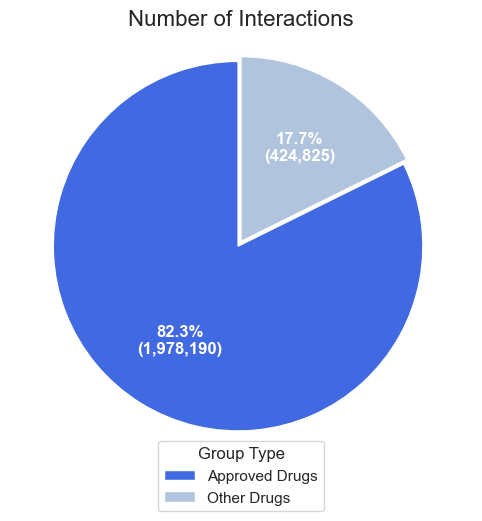

In [12]:
data = [approved_df.shape[0], not_approved_df.shape[0]]
labels = ['Approved Drugs', 'Other Drugs']


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,})".format(pct, absolute)


fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(data,
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  explode=(0.03, 0),
                                  colors=['royalblue', 'lightsteelblue'],
                                  startangle=90
                                 )
ax.legend(wedges, labels,
          title="Group Type",
          loc="lower center",
          bbox_to_anchor=(0.25, -0.1, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("Number of Interactions", fontsize=16, y=0.95)
plt.show()

In [20]:
# Save Not Approved Drugs for test set
val_test_drug_split = round(len(not_approved_drugs)/2)
np.random.shuffle(not_approved_drugs)
val_drugs = not_approved_drugs[:val_test_drug_split]

val_df = not_approved_df[not_approved_df["d1"].isin(val_drugs) | not_approved_df["d2"].isin(val_drugs)]
test_df = not_approved_df[~(not_approved_df["d1"].isin(val_drugs) | not_approved_df["d2"].isin(val_drugs))]

val_df = val_df.sample(frac=1, random_state=42)
val_df = val_df.reset_index()
val_df = val_df.drop('index', axis=1)


test_df = test_df.sample(frac=1, random_state=42)
test_df = test_df.reset_index()
test_df = test_df.drop('index', axis=1)

# Save test set
# save the dataframe to csv file
# not_approved_df.to_csv('data/ddi_test_api.csv', index=False)

In [21]:
print('Test dataset shape:', test_df.shape)
print('Number of interaction types in test set:', len(test_df.interaction_type.unique()))
print('Interaction type distribution in test set, Bottom 10:')
print(test_df.interaction_type.value_counts()[-10:])
test_df.head(1)

Test dataset shape: (216352, 13)
Number of interaction types in test set: 2
Interaction type distribution in test set, Bottom 10:
1    136030
0     80322
Name: interaction_type, dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB00597,DB13432,Gadoteridol,Lonazolac,#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.,1,unknown,[Gd+3].CC(O)CN1CCN(CC([O-])=O)CCN(CC([O-])=O)CCN(CC([O-])=O)CC1,OC(=O)CC1=CN(N=C1C1=CC=C(Cl)C=C1)C1=CC=CC=C1,Not Available,"Based on the behavior of protons when placed in a strong magnetic field, which is interpreted and transformed into images by magnetic resonance (MR) instruments. Paramagnetic agents have unpaired ...",Not Available,Not Available


In [22]:
print('Validation dataset shape:', val_df.shape)
print('Number of interaction types in Validation set:', len(val_df.interaction_type.unique()))
print('Interaction type distribution in Validation set, Bottom 10:')
print(val_df.interaction_type.value_counts()[-10:])
val_df.head(1)

Validation dataset shape: (208473, 13)
Number of interaction types in Validation set: 2
Interaction type distribution in Validation set, Bottom 10:
1    122511
0     85962
Name: interaction_type, dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB00318,DB12221,Codeine,Canrenone,The therapeutic efficacy of #Drug2 can be decreased when used in combination with #Drug1.,1,unknown,[H][C@]12C=C[C@H](O)[C@@H]3OC4=C5C(C[C@H]1N(C)CC[C@@]235)=CC=C4OC,[H][C@@]12CC[C@@]3(CCC(=O)O3)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])C=CC2=CC(=O)CC[C@]12C,"Category: A, Protein: Mu-type opioid receptor, Actions: agonist | Category: A, Protein: Kappa-type opioid receptor, Actions: regulator | Category: A, Protein: Delta-type opioid receptor, Actions: ...","Codeine is a selective agonist for the mu opioid receptor, but with a much weaker affinity to this receptor than morphine, a more potent opioid drug. Codeine binds to mu-opioid receptors, which ar...",Not Available,Not Available


In [23]:
approved_df = approved_df.sample(frac=1, random_state=42)
approved_df = approved_df.reset_index()
approved_df = approved_df.drop('index', axis=1)

print('Training dataset shape:', approved_df.shape)
print('Number of interaction types in Validation set:', len(approved_df.interaction_type.unique()))
print('Interaction type distribution in Validation set, Bottom 10:')
print(approved_df.interaction_type.value_counts()[-10:])
approved_df.head(1)

Training dataset shape: (1978191, 13)
Number of interaction types in Validation set: 2
Interaction type distribution in Validation set, Bottom 10:
1    1142233
0     835958
Name: interaction_type, dtype: int64


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB09281,DB13987,Magnesium trisilicate,Strontium chloride,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.,1,unknown,[Mg++].[Mg++].[O-][Si](=O)O[Si]([O-])([O-])O[Si]([O-])=O,[Cl-].[Cl-].[Sr++],Not Available,"The gelatinous silicon dioxide, formed by the reaction of magnesium trisilicate with gastric contents is said to protect ulcerated mucosal surfaces and favor healing.",Not Available,"For dental hypersensitivity, strontium ions in strontium chloride toothpaste formulations appear to relieve pain and sensitivity by blocking fluid flow in dentinal tubules, which are essentially m..."


In [78]:
1142233/1978191

0.577412898956673

In [24]:
# save the dataframe to csv file
test_df.to_csv('data/binary_ddi/ddi_test_binary_with_target.csv', index=False, sep='\t')
val_df.to_csv('data/binary_ddi/ddi_val_binary_with_target.csv', index=False, sep='\t')

approved_df.to_csv('data/binary_ddi/ddi_train_binary_with_target.csv', index=False, sep='\t')

In [ ]:
approved_df = pd.read_csv('data/binary_ddi/ddi_train_binary_with_target.csv', sep='\t')

## 6. Under-Sampling & Up-Sampling

In [25]:
# Set the display.max_rows option to None
# pd.set_option("display.max_rows", None)

print('Training set label distribution:')
# approved_df = approved_df[["d1", "d2", "interaction_type", "severity"]]
approved_df.interaction_type.value_counts()

Training set label distribution:


1    1142233
0     835958
Name: interaction_type, dtype: int64

ConversionError: Failed to convert value(s) to axis units: ['Approved Drugs', 'Other Drugs']

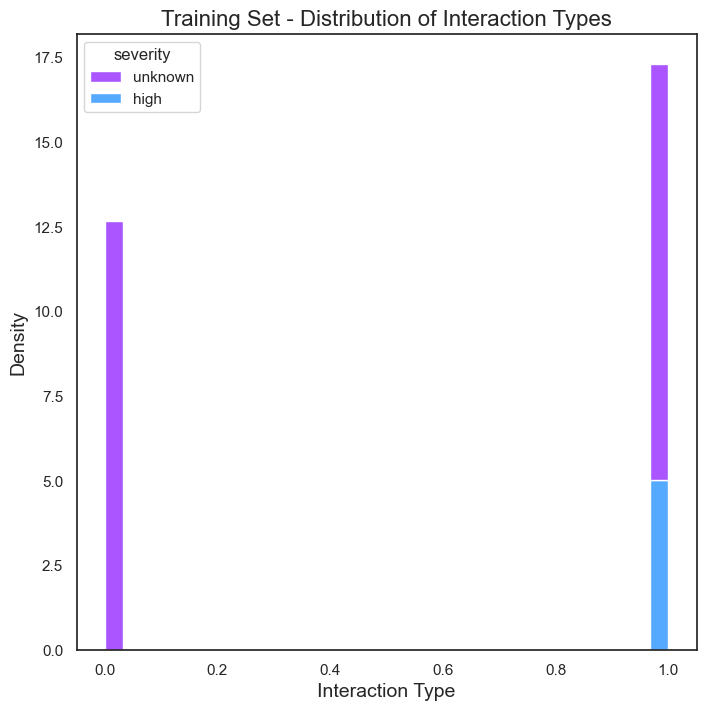

In [26]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=approved_df, x='interaction_type', bins = 30, alpha=1,
             hue="severity", multiple="stack", palette='cool_r', stat='density')
plt.ylabel('Density', fontsize=14)
plt.xlabel('Interaction Type', fontsize=14)
plt.title('Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
# labels = list(range(0, 90, 5))
plt.xticks(labels)
plt.show()

In [27]:
from sklearn.utils import resample

def balance_dataset(df, n_samples=10000, random_state=42):
    label_counts = df.interaction_type.value_counts()

    ## Downsample Majority cClasses
    # Get majority classes (all labels >= n_samples)
    majority_classes = approved_df.interaction_type.value_counts()\
        [approved_df.interaction_type.value_counts() >= n_samples].index

    # Initialize
    df_majorities = pd.DataFrame(data=[],
                                 columns=['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2'])

    for i in range(len(majority_classes)):
        label = majority_classes[i]
        df_majority = df[df["interaction_type"] == label]
        df_downsample = resample(df_majority,
                                replace=False,     # sample without replacement
                                n_samples=n_samples,    # change majority to minority clas
                                random_state=random_state)
        # Add each majority class to down_sample df:
        # Combine all downsampled majority classes
        df_majorities = pd.concat([df_majorities, df_downsample])


    ## Upsample Minority Classes
    # Get majority classes (all labels < n_samples)
    minority_classes = approved_df.interaction_type.value_counts()\
        [approved_df.interaction_type.value_counts() < n_samples].index

    # Initialize
    df_minorities = pd.DataFrame(data=[],
                                 columns=['d1', 'd2', 'd1_name', 'd2_name', 'interaction','interaction_type', 'severity', 'smiles1', 'smiles2'])

    for i in range(len(minority_classes)):
        label = minority_classes[i]
        df_minority = df[df["interaction_type"] == label]
        df_upsample = resample(df_minority,
                                replace=True,     # sample WITH replacement
                                n_samples=n_samples,    # change majority to minority clas
                                random_state=random_state)
        # Add each minority class to up-sample df:
        # Combine all Up-sampled minority classes
        df_minorities = pd.concat([df_minorities, df_upsample])

    ## Combine Upsample & Downsample data
    df = pd.concat([df_majorities, df_minorities])
    df = df.sample(frac=1, random_state=42)
    df = df.reset_index()
    df = df.drop('index', axis=1)

    return df

### Balance to have 150,000 each label

In [28]:
## Balance data with each label = 150,000 samples
balance_df_150k = balance_dataset(approved_df, n_samples=150000)
print(balance_df_150k.shape)
balance_df_150k.head(2)

(300000, 13)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB01501,DB00356,Difenoxin,Chlorzoxazone,The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.,1,high,OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)CC1)C1=CC=CC=C1,ClC1=CC2=C(OC(=O)N2)C=C1,Not Available,"Difenoxin acts as an antidiarrheal by activating peripheral opioid receptors in the small intestine and thereby inhibiting peristalsis. However, research has suggested that non-opioid receptor pat...",Not Available,"Chlorzoxazone inhibits degranulation of mast cells, subsequently preventing the release of histamine and slow-reacting substance of anaphylaxis (SRS-A), mediators of type I allergic reactions. Chl..."
1,DB00208,DB00242,Ticlopidine,Cladribine,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC(Cl)=N1,"Category: A, Protein: P2Y purinoceptor 12, Actions: antagonist","The active metabolite of ticlopidine prevents binding of adenosine diphosphate (ADP) to its platelet receptor, impairing the ADP-mediated activation of the glycoprotein GPIIb/IIIa complex. It is p...","Category: A, Protein: Ribonucleoside-diphosphate reductase large subunit, Actions: inhibitor | Category: A, Protein: Ribonucleoside-diphosphate reductase subunit M2, Actions: inhibitor | Category:...","Cladribine is structurally related to fludarabine and pentostatin but has a different mechanism of action. Although the exact mechanism of action has not been fully determined, evidence shows that..."


In [29]:
## Balance data with each label 400,000 samples
balance_df_400k = balance_dataset(approved_df, n_samples=400000)
print(balance_df_400k.shape)
balance_df_400k.head(2)

(800000, 13)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB07565,DB00721,Chloramphenicol succinate,Procaine,The risk or severity of methemoglobinemia can be increased when #Drug1 is combined with #Drug2.,1,high,O[C@@H]([C@@H](COC(=O)CCC(O)=O)NC(=O)C(Cl)Cl)C1=CC=C(C=C1)[N+]([O-])=O,CCN(CC)CCOC(=O)C1=CC=C(N)C=C1,"Category: U, Protein: Dr hemagglutinin structural subunit, Actions: inhibitor",Chloramphenicol succinate is hydrolyzed into the active chloramphenicol.1 Chloramphenicol resembles uridine-5'-phosphate.6 It binds to the residues A2451 and A2452 in the 23S rRNA of the 50S ribos...,"Category: A, Protein: Sodium channel protein type 10 subunit alpha, Actions: inhibitor | Category: A, Protein: Glutamate receptor ionotropic, NMDA 3A, Actions: antagonist | Category: A, Protein: 5...","Procaine acts mainly by inhibiting sodium influx through voltage gated sodium channels in the neuronal cell membrane of peripheral nerves. When the influx of sodium is interrupted, an action poten..."
1,DB09053,DB05260,Ibrutinib,Gallium nitrate,The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.,1,high,NC1=NC=NC2=C1C(=NN2[C@@H]1CCCN(C1)C(=O)C=C)C1=CC=C(OC2=CC=CC=C2)C=C1,[Ga+3].[O-][N+]([O-])=O.[O-][N+]([O-])=O.[O-][N+]([O-])=O,"Category: A, Protein: Tyrosine-protein kinase BTK, Actions: inhibitor","Ibrutinib is an inhibitor of Bruton’s tyrosine kinase (BTK). It forms a covalent bond with a cysteine residue in the active site of BTK (Cys481), leading to its inhibition. The inhibition of BTK p...","Category: A, Protein: Ribonucleoside-diphosphate reductase subunit M2, Actions: inhibitor | Category: A, Protein: V-type proton ATPase subunit B, brain isoform, Actions: inhibitor | Category: A, P...","Gallium nitrate is believed to exert a hypocalcemic effect by inhibiting calcium resorption from bone. Gallium nitrate localizes preferentially where bone resorption and remodeling is occurring, a..."


In [30]:
## Balance data with each label = 10,000 samples
balance_df_835k = balance_dataset(approved_df, n_samples=835985)
print(balance_df_835k.shape)
balance_df_835k.head(2)

(1671970, 13)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action
0,DB00877,DB00944,Sirolimus,Demecarium,Unknown,0,unknown,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C=C(C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(C)\[C@H](C[C@]3([H])CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCC[C@@]3([H])C(=O)O2)OC)CC[C@@H](...,CN(CCCCCCCCCCN(C)C(=O)OC1=CC=CC(=C1)[N+](C)(C)C)C(=O)OC1=CC=CC(=C1)[N+](C)(C)C,"Category: A, Protein: Serine/threonine-protein kinase mTOR, Actions: inhibitor","Sirolimus works by inhibiting T-lymphocyte activation and proliferation stimulated by antigens and cytokines such as interleukin (IL)-2, IL-4, and IL-15. In target cells, sirolimus binds to the cy...","Category: A, Protein: Acetylcholinesterase, Actions: inhibitor | Category: U, Protein: Cholinesterase, Actions: inhibitor","Demecarium is an indirect-acting parasympathomimetic agent, also known as a cholinesterase inhibitor and anticholinesterase. Cholinesterase inhibitors prolong the effect of acetylcholine, which is..."
1,DB00238,DB00945,Nevirapine,Acetylsalicylic acid,The metabolism of #Drug2 can be decreased when combined with #Drug1.,1,unknown,CC1=C2NC(=O)C3=C(N=CC=C3)N(C3CC3)C2=NC=C1,CC(=O)OC1=CC=CC=C1C(O)=O,"Category: A, Protein: Reverse transcriptase/RNaseH, Actions: inhibitor",Nevirapine binds directly to reverse transcriptase (RT) and blocks the RNA-dependent and DNA-dependent DNA polymerase activities by causing a disruption of the enzyme's catalytic site. The activit...,"Category: A, Protein: Prostaglandin G/H synthase 1, Actions: inhibitor | Category: A, Protein: Prostaglandin G/H synthase 2, Actions: inhibitor | Category: U, Protein: Aldo-keto reductase family 1...","Acetylsalicylic acid (ASA) blocks prostaglandin synthesis. It is non-selective for COX-1 and COX-2 enzymes 9,10,11. Inhibition of COX-1 results in the inhibition of platelet aggregation for about ..."


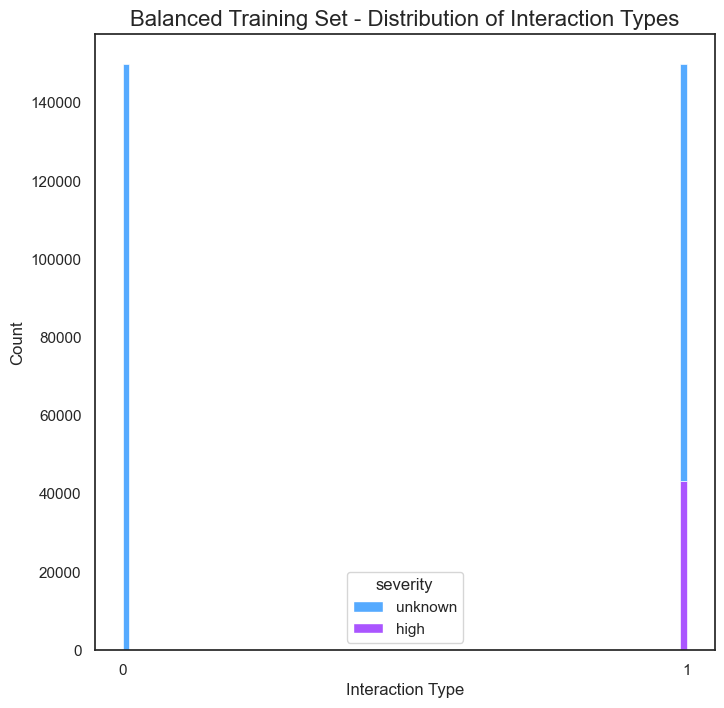

In [75]:
fig = plt.figure(figsize=(8,8))
sns.set_style('white')
sns.histplot(data=balance_df_150k, x='interaction_type',bins = 87, alpha=1,
             hue="severity", multiple="stack", palette='cool')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Interaction Type', fontsize=12)
plt.title('Balanced Training Set - Distribution of Interaction Types', fontsize=16)
# plt.xticks(rotation=0)
labels = list(range(2))
plt.xticks(labels)
plt.show()

In [31]:
# Save Balance Training Data
# save the dataframe to csv file
balance_df_150k.to_csv('data/binary_ddi/ddi_train_balanced_with_target_150k.csv', index=False, sep='\t')

In [32]:
# save the dataframe to csv file
balance_df_400k.to_csv('data/binary_ddi/ddi_train_balanced_with_target_400k.csv', index=False, sep='\t')

In [77]:
# Save Balance Training Data
# save the dataframe to csv file
balance_df_835k.to_csv('data/binary_ddi/ddi_train_balanced_with_target_835k.csv', index=False, sep='\t')

In [42]:
# Create a new column to combine target & action to a single column, trim it to max 250 words for each drug
df = val_df.copy()

def trim_to_250_words(text):
    words = text.split()
    return " ".join(words[:250])

# df["d1_target_action"] = df["d1_target"] + " | " + df["d1_action"]
# df["d1_target_action"] = df["d1_target_action"].apply(trim_to_250_words)
#
# df["d2_target_action"] = df["d2_target"] + " | " + df["d2_action"]
# df["d2_target_action"] = df["d2_target_action"].apply(trim_to_250_words)

df["d1_target"] = df["d1_target"].str.replace('|', '.').str.replace(':','')
df["d1_target"] = df["d1_target"].apply(trim_to_250_words)
df["d2_target"] = df["d2_target"].str.replace('|', '.').str.replace(':','')
df["d2_target"] = df["d2_target"].apply(trim_to_250_words)

df["target_features"] = "Drug1: " + df["d1_target"] + " [SEP] " + "Drug2: " + df["d2_target"] + "[SEP]"


print(df["target_features"][2])
df.head()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_24976\3516048953.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["d1_target"] = df["d1_target"].str.replace('|', '.').str.replace(':','')
C:\Users\ltmai\AppData\Local\Temp\ipykernel_24976\3516048953.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["d2_target"] = df["d2_target"].str.replace('|', '.').str.replace(':','')


Drug1: Not Available [SEP] Drug2: Category A, Protein Sodium-dependent serotonin transporter, Actions inhibitor . Category A, Protein Sodium-dependent noradrenaline transporter, Actions inhibitor . Category U, Protein NMDA receptor, Actions inhibitor[SEP]


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,d1_target,d1_action,d2_target,d2_action,target_features
0,DB00318,DB12221,Codeine,Canrenone,The therapeutic efficacy of #Drug2 can be decreased when used in combination with #Drug1.,1,unknown,[H][C@]12C=C[C@H](O)[C@@H]3OC4=C5C(C[C@H]1N(C)CC[C@@]235)=CC=C4OC,[H][C@@]12CC[C@@]3(CCC(=O)O3)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])C=CC2=CC(=O)CC[C@]12C,"Category A, Protein Mu-type opioid receptor, Actions agonist . Category A, Protein Kappa-type opioid receptor, Actions regulator . Category A, Protein Delta-type opioid receptor, Actions agonist","Codeine is a selective agonist for the mu opioid receptor, but with a much weaker affinity to this receptor than morphine, a more potent opioid drug. Codeine binds to mu-opioid receptors, which ar...",Not Available,Not Available,"Drug1: Category A, Protein Mu-type opioid receptor, Actions agonist . Category A, Protein Kappa-type opioid receptor, Actions regulator . Category A, Protein Delta-type opioid receptor, Actions ag..."
1,DB00865,DB02134,Benzphetamine,Xanthine,The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.,1,high,C[C@@H](CC1=CC=CC=C1)N(C)CC1=CC=CC=C1,O=C1NC2=C(NC=N2)C(=O)N1,"Category A, Protein Synaptic vesicular amine transporter, Actions inducer . Category A, Protein Alpha-2A adrenergic receptor, Actions agonist . Category A, Protein Alpha-1A adrenergic receptor, Ac...","The mechanism of action of these drugs is not fully understood, however it may be similar to that of amphetamines. Amphetamines stimulate noepinephrine and dopamine release in nerve endings in the...",Not Available,Not Available,"Drug1: Category A, Protein Synaptic vesicular amine transporter, Actions inducer . Category A, Protein Alpha-2A adrenergic receptor, Actions agonist . Category A, Protein Alpha-1A adrenergic recep..."
2,DB04828,DB04896,Zomepirac,Milnacipran,The risk or severity of gastrointestinal bleeding can be increased when #Drug1 is combined with #Drug2.,1,high,CN1C(CC(O)=O)=CC(C)=C1C(=O)C1=CC=C(Cl)C=C1,CCN(CC)C(=O)C1(CC1CN)C1=CC=CC=C1,Not Available,Not Available,"Category A, Protein Sodium-dependent serotonin transporter, Actions inhibitor . Category A, Protein Sodium-dependent noradrenaline transporter, Actions inhibitor . Category U, Protein NMDA recepto...",The dual ability for milnacipran to inhibit the reuptake of both serotonin (5HT) and norepinephrine (NE) facilitates its treatment of both fibromyalgia and major depressive disorder (MDD). | In pa...,"Drug1: Not Available [SEP] Drug2: Category A, Protein Sodium-dependent serotonin transporter, Actions inhibitor . Category A, Protein Sodium-dependent noradrenaline transporter, Actions inhibitor ..."
3,DB00546,DB00987,Adinazolam,Cytarabine,Unknown,0,unknown,CN(C)CC1=NN=C2CN=C(C3=CC=CC=C3)C3=C(C=CC(Cl)=C3)N12,NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)[C@@H]1O,"Category A, Protein GABA(A) Receptor, Actions positive allosteric modulator . Category A, Protein GABA(A) Receptor Benzodiazepine Binding Site, Actions ligand","Adinazolam binds to peripheral-type benzodiazepine receptors which interact allosterically with GABA receptors. This potentiates the effects of the inhibitory neurotransmitter GABA, increasing the...","Category A, Protein DNA polymerase beta, Actions inhibitor . Category A, Protein DNA, Actions cross-linking/alkylation","Cytarabine acts through direct DNA damage and incorporation into DNA. Cytarabine is cytotoxic to a wide variety of proliferating mammalian cells in culture. It exhibits cell phase specificity, pri...","Drug1: Category A, Protein GABA(A) Receptor, Actions positive allosteric modulator . Category A, Protein GABA(A) Receptor Benzodiazepine Binding Site, Actions ligand [SEP] Drug2: Category A, Prote..."
4,DB00453,DB13925,Clomocycline,Dotatate gallium Ga-68,Unknown,0,unknown,[H][C@@]12C[C@@]3([H])C(=C(O)[C@]1(O)C(=O)C(C(=O)NCO)=C(O)[C@H]2N(C)C)C(=O)C1=C(C(Cl)=CC=C1O)[C@@]3(C)O,[68Ga+3].C[C@@H](O)[C@H](NC(=